In [1]:
%autosave 60
%pip install --quiet -r requirements.txt

Autosaving every 60 seconds
Note: you may need to restart the kernel to use updated packages.


## Setup

In [1]:
import os
import numpy as np
import random
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
from utils.data_loader import DataLoader
from utils.data_converter import DataConverter
from utils.data_analyser import DataAnalyser
from models.unet_3d_std import UNet3D
from models.unet_3d_res import ResidualUNet3D
from utils.train_eval import fit_3D
from utils.loss_functions import ssim_loss, l1_loss

data_loader = DataLoader()
data_converter = DataConverter()
data_analyser = DataAnalyser()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


Flush cuda memory

In [2]:
torch.cuda.empty_cache()

Common Variables

In [3]:
model_epochs            = 2000
snapshot_every          = 500
model_checkpoint_every  = 250

img_crop_axes = ((16, 10, 0), (17, 11, 17))

In [4]:
training_pairs, validation_pairs, test_pairs = data_loader.split_dataset_paths(seed=69) # Standard 70/20/10 split
print("We have", len(training_pairs), "training pairs")
print("We have", len(test_pairs), "test pairs")

We have 492 training pairs
We have 106 test pairs


## 3D U-Net

### Model Training

In [6]:
output_dir = "out/unets"
unet_path = f"{output_dir}/3d_unet_model_standard.pt"
unet = UNet3D(in_ch=1, base=32).to(device)
unet_optimizer = optim.AdamW(unet.parameters(), lr=1e-4, weight_decay=1e-4)

In [ ]:
# Load existing model if it exists
if os.path.isfile(unet_path):
    print("Loading existing model")
    unet.load_state_dict(torch.load(unet_path))
else:
    print("No existing 3D U-Net found, starting fresh training.")
    os.makedirs(output_dir, exist_ok=True)
    
print(len(training_pairs), "training pairs")

TODO Re-implementer når ikke ass


In [8]:
unet, unet_losses, unet_snapshots, unet_best = fit_3D(
    model=unet,
    device=device,
    training_pairs=training_pairs,
    validation_pairs=validation_pairs,
    epochs=model_epochs,
    loss_func=ssim_loss,
    dataConverter=data_converter,
    optimizer=unet_optimizer,
    snapshot_every=snapshot_every,
    checkpoint_every=model_checkpoint_every,
    crop_axes=img_crop_axes,
)

Training 3D Residual U-Net:   0%|          | 0/2000 [00:00<?, ?it/s]

Training 3D Residual U-Net: 100%|██████████| 2000/2000 [52:03<00:00,  1.56s/it, Best loss on val 0.085570, (Iter 1750)]  


Displaying snapshot from pair 0, loss: 1.0121


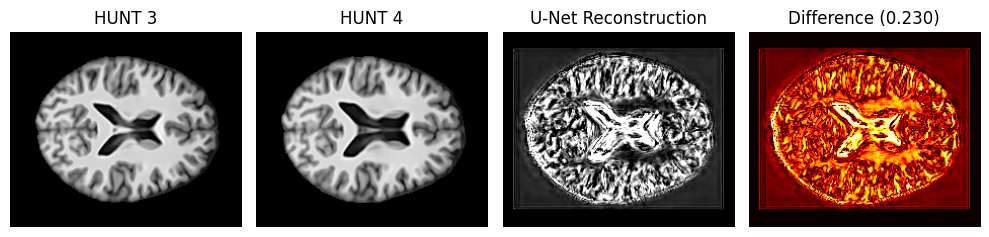

Displaying snapshot from pair 500, loss: 0.1184


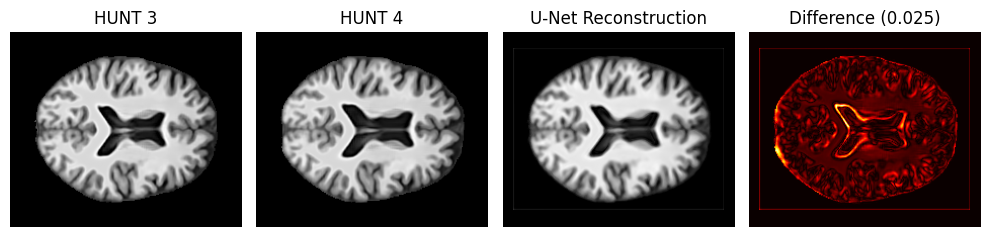

Displaying snapshot from pair 1000, loss: 0.0887


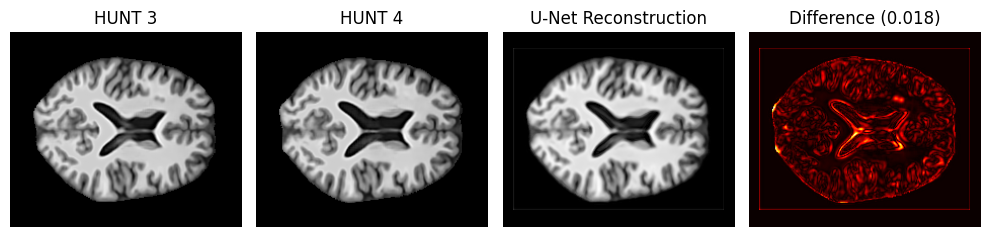

Displaying snapshot from pair 1500, loss: 0.1052


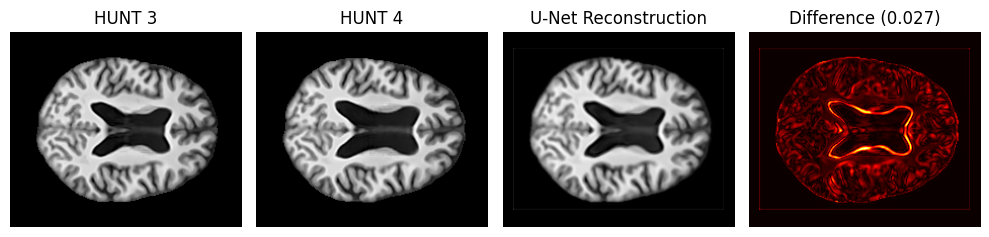

Displaying snapshot from pair 1999, loss: 0.1275


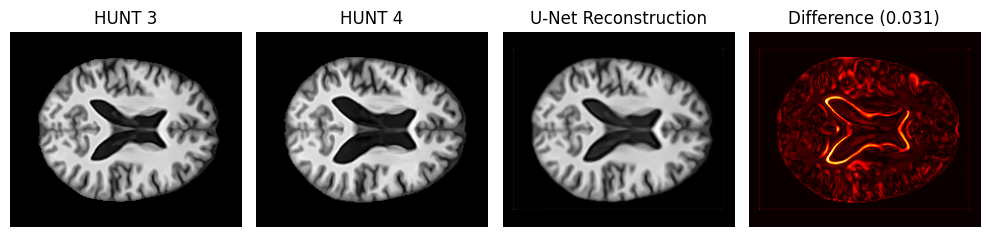

In [9]:
for snapshot in unet_snapshots:
    print(f"Displaying snapshot from pair {snapshot['iter']}, loss: {snapshot['loss']:.4f}")
    difference = np.abs(snapshot["recon"] - snapshot["y"])
    data_analyser.display_slices([snapshot["x"], snapshot["y"], snapshot["recon"], difference], slice_labels=["HUNT 3", "HUNT 4", "U-Net Reconstruction", f"Difference ({np.mean(difference):.3f})"], slice_colors=["gray", "gray", "gray", "hot"])

In [10]:
# Save the final model to the /out directory
torch.save(unet.state_dict(), unet_path)
print(f"Model saved to {unet_path}")

Model saved to out/unets/3d_unet_model_standard.pt


### Model Evaluation over Testset

In [5]:
output_dir = "out/unets"
unet_path = f"{output_dir}/3d_unet_model_standard.pt"

# Import model before testing
unet = UNet3D(in_ch=1, base=32).to(device)
unet.load_state_dict(torch.load(unet_path))
print("Loaded trained model for testing.")

Loaded trained model for testing.


In [6]:
unet.eval()
avg_unet_loss = 0.0

# Estimate Accuracy over testset
for (input_path, target_path) in tqdm(test_pairs):
    # Import image from paths
    input_full, target_full = data_converter.load_path_as_tensor(input_path), data_converter.load_path_as_tensor(target_path)
    input, target = data_converter.get_volume_with_3d_change(tensor=input_full, crop_axes=img_crop_axes, remove_mode=True), data_converter.get_volume_with_3d_change(tensor=target_full, crop_axes=img_crop_axes, remove_mode=True)

    # Get Reconstructions
    unet_recon = unet(input)
    target_num = target

    # calculate 3d loss
    avg_unet_loss += ssim_loss(unet_recon, target_num).item()

avg_unet_loss /= len(test_pairs)

print(f"Average U-Net 3D Loss over Test Set: {avg_unet_loss:.4f}")

# We save the model with the test loss in the filename for easy identification
test_unet_path = f"{output_dir}/3d_unet_model_standard_testloss_{avg_unet_loss:.4f}.pt"
torch.save(unet.state_dict(), test_unet_path)
print(f"Test model saved to {test_unet_path}")

100%|██████████| 106/106 [00:57<00:00,  1.83it/s]

Average U-Net 3D Loss over Test Set: 0.0879
Test model saved to out/unets/3d_unet_model_standard_testloss_0.0879.pt


## Residual 3D U-Net

### Model Training

In [6]:
output_dir = "out/unets"
unet_path = f"{output_dir}/3d_res_unet_model.pt"
unet = ResidualUNet3D(in_ch=1, base=32).to(device)
unet_optimizer = optim.AdamW(unet.parameters(), lr=1e-4, weight_decay=1e-4)

In [7]:
# Load existing model if it exists
if os.path.isfile(unet_path):
    print("Loading existing model")
    unet.load_state_dict(torch.load(unet_path))
else:
    print("No existing 3D U-Net found, starting fresh training.")
    os.makedirs(output_dir, exist_ok=True)
    
print(len(training_pairs), "training pairs")

No existing 3D U-Net found, starting fresh training.
492 training pairs


In [8]:
unet, unet_losses, unet_snapshots, unet_best = fit_3D(
    model=unet,
    device=device,
    training_pairs=training_pairs,
    validation_pairs=validation_pairs,
    epochs=model_epochs,
    loss_func=ssim_loss,
    dataConverter=data_converter,
    optimizer=unet_optimizer,
    snapshot_every=snapshot_every,
    checkpoint_every=model_checkpoint_every,
    crop_axes=img_crop_axes,
)

Training 3D Residual U-Net:   0%|          | 0/2000 [00:00<?, ?it/s]

Training 3D Residual U-Net: 100%|██████████| 2000/2000 [44:55<00:00,  1.35s/it, Best loss on val 0.080007, (Iter 1750)]  


Displaying snapshot from pair 0, loss: 0.9476


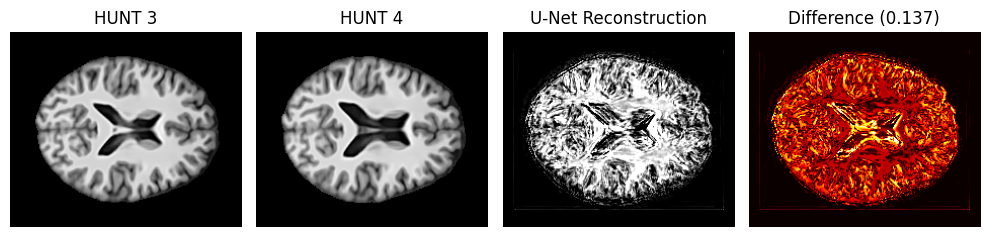

Displaying snapshot from pair 500, loss: 0.1197


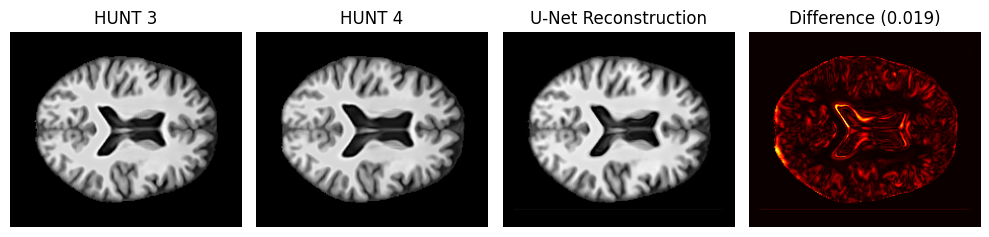

Displaying snapshot from pair 1000, loss: 0.0893


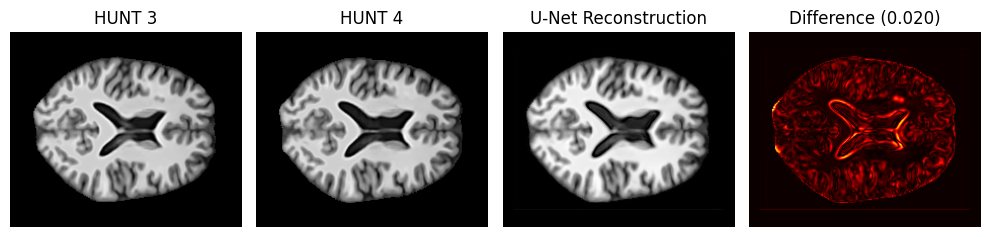

Displaying snapshot from pair 1500, loss: 0.0940


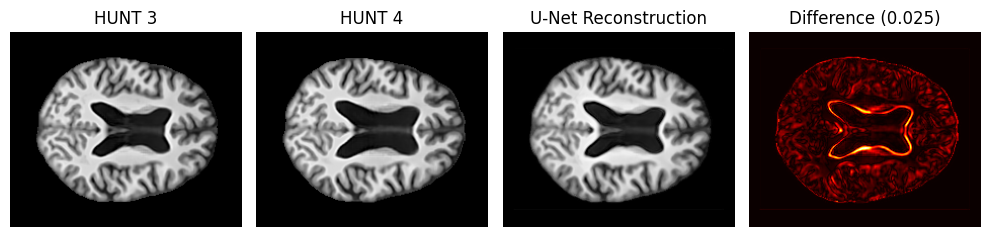

Displaying snapshot from pair 1999, loss: 0.1035


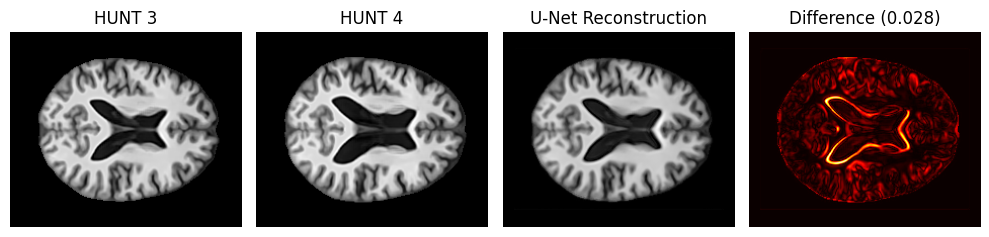

In [9]:
for snapshot in unet_snapshots:
    print(f"Displaying snapshot from pair {snapshot['iter']}, loss: {snapshot['loss']:.4f}")
    difference = np.abs(snapshot["recon"] - snapshot["y"])
    data_analyser.display_slices([snapshot["x"], snapshot["y"], snapshot["recon"], difference], slice_labels=["HUNT 3", "HUNT 4", "U-Net Reconstruction", f"Difference ({np.mean(difference):.3f})"], slice_colors=["gray", "gray", "gray", "hot"])

In [10]:
# Save the final model to the /out directory
torch.save(unet.state_dict(), unet_path)
print(f"Model saved to {unet_path}")

Model saved to out/unets/3d_res_unet_model.pt


### Model Evaluation over Testset

In [11]:
output_dir = "out/unets"
unet_path = f"{output_dir}/3d_res_unet_model.pt"

# Import model before testing
unet = ResidualUNet3D(in_ch=1, base=32).to(device)
unet.load_state_dict(torch.load(unet_path))
print("Loaded trained model for testing.")

Loaded trained model for testing.


In [ ]:
unet.eval()
avg_unet_loss = 0.0

# Estimate Accuracy over testset
for (input_path, target_path) in tqdm(test_pairs):
    # Import image from paths
    input_full, target_full = data_converter.load_path_as_tensor(input_path), data_converter.load_path_as_tensor(target_path)
    input, target = data_converter.get_volume_with_3d_change(tensor=input_full, crop_axes=img_crop_axes, remove_mode=True), data_converter.get_volume_with_3d_change(tensor=target_full, crop_axes=img_crop_axes, remove_mode=True)

    # Get Reconstructions
    unet_recon, _ = unet(input)
    target_num = target

    # calculate 3d loss
    avg_unet_loss += ssim_loss(unet_recon, target_num).item()

avg_unet_loss /= len(test_pairs)

print(f"Average U-Net 3D Loss over Test Set: {avg_unet_loss:.4f}")

# We save the model with the test loss in the filename for easy identification
test_unet_path = f"{output_dir}/3d_unet_model_standard_testloss_{avg_unet_loss:.4f}.pt"
torch.save(unet.state_dict(), test_unet_path)
print(f"Test model saved to {test_unet_path}")

100%|██████████| 106/106 [01:10<00:00,  1.50it/s]

Average U-Net 3D Loss over Test Set: 0.0829
Test model saved to out/unets/3d_unet_model_standard_testloss_0.0829.pt
